In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import astropy.time
import astropy.units as u
import astropy.constants as c
import emcee
import corner

custom_mplstyle = ("https://raw.githubusercontent.com/FoxFortino"
                   "/DSPS_WFortino/main/custom.mplstyle")
plt.style.use(custom_mplstyle)

In [2]:
# Path to OGLE data: 
OGLE_CSV = ("https://raw.githubusercontent.com/Somayeh91"
             "/Data_Science_class_UD_fall_2021"
             "/main/data/OGLE_2012_BLG_1323.csv")

# Path to Roman data:
ROMAN_CSV = ("https://raw.githubusercontent.com/Somayeh91"
              "/Data_Science_class_UD_fall_2021"
              "/main/data/mag.dcnormffp_0_82_1902.det.lc.W149.csv")

In [3]:
ogle = pd.read_csv(OGLE_CSV)
roman = pd.read_csv(ROMAN_CSV)

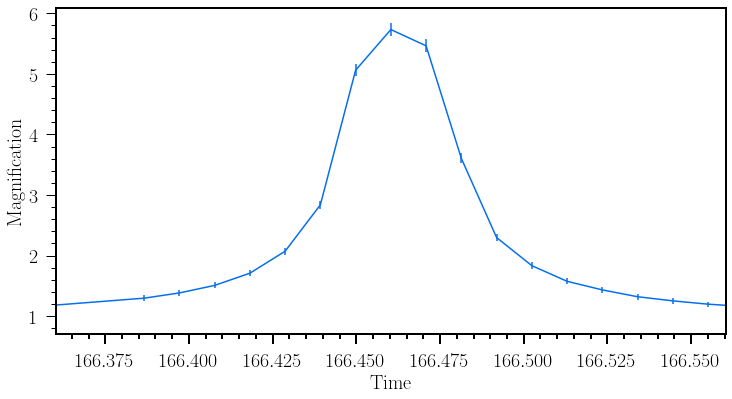

In [4]:
plt.figure(figsize=(12, 6))
plt.errorbar(roman.t, roman.A, yerr=roman.A_err*10)
peak = roman.t[np.argmax(roman.A)]

dt = 0.1
plt.xlim(peak-dt, peak+dt)

plt.xlabel("Time")
plt.ylabel("Magnification")

plt.show()

In [5]:
def PSPL(t, t0, tE, u0, fs):
    """
    PSPL Model for microlensing events.
    """
    u = np.sqrt(u0**2 +((t-t0)/tE)**2)
    A = (u**2 + 2) / (u + np.sqrt(u**2 + 4))
    F = (fs * A) + (1 - fs)
    return F


def cauchy(t, t0, amp, sigma, b):
    """
    Cauchy model for microlensing events.
    """
    C = 1 + (amp / (1 + np.abs((t - t0) / sigma)**(2 * b)))
    return C


def L1(args, x, y, func):
    return np.sum(np.abs(y - func(x, *args)))


def L2(args, x, y, func):
    return np.sum((y - func(x, *args))**2)


def chi2(args, x, y, sigma, func):
    return np.sum((y - func(x, *args))**2 / sigma**2)

L2 unit test: result should be 111.93751462 -8.33237568: [111.93751614  -8.3323759 ]
chi2 unit test: result should be 104.93611121 -7.21374685: [104.93609417  -7.21374452]


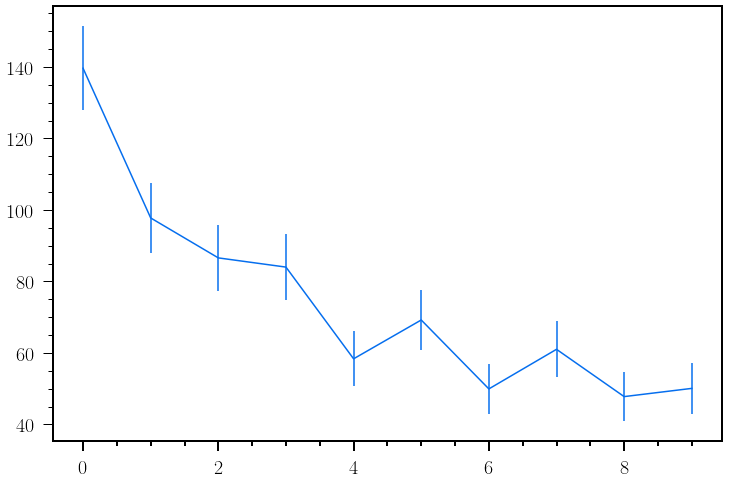

In [6]:
# Unit test
def line(a, b, x):
    return a*x + b

np.random.seed(222)
y = np.array([120, 95, 82, 74, 66, 62, 59, 51, 53, 47])
y = y + np.random.randn(len(y)) * 10
yerr = np.sqrt(y)
x = np.arange(len(y))
plt.errorbar(x, y, yerr=yerr);
print("L2 unit test: result should be 111.93751462 -8.33237568:", sp.optimize.minimize(L2, (10,40), args=(x, y, line)).x)
print("chi2 unit test: result should be 104.93611121 -7.21374685:", sp.optimize.minimize(chi2, (10,40), args=(x, y, yerr, line)).x)

In [7]:
def opt_3_ways(model, P0, x, y, sigma):
    opt_L1 = sp.optimize.minimize(L1, P0,
                                   args=(x, y, model))
    opt_L2 = sp.optimize.minimize(L2, P0,
                                   args=(x, y, model))
    opt_chisq = sp.optimize.minimize(chi2, P0,
                                      args=(x, y, sigma, model))
    return opt_L1, opt_L2, opt_chisq

In [8]:
# Opt Roman
x = roman.t.values
y = roman.A.values
sigma = roman.A_err.values

P0 = (peak, 0.1, 0.02, 0.46)

opt = opt_3_ways(PSPL, P0, x, y, sigma)
opt_roman_PSPL_L1, opt_roman_PSPL_L2, opt_roman_PSPL_chi2 = opt

opt = opt_3_ways(cauchy, P0, x, y, sigma)
opt_roman_cauchy_L1, opt_cauchy_PSPL_L2, opt_cauchy_PSPL_chi2 = opt

In [9]:
def plot_fit(x, y, sigma, params, model, dt=10):
    
    plt.figure(figsize=(12, 6))
    
    data_peak = x[np.argmax(y)]
    
    y_hat = model(x, *params)
    model_peak = x[np.argmax(y_hat)]
    
    plt.errorbar(x, y, yerr=sigma)
    plt.plot(x, y_hat)

    plt.xlim(np.min((data_peak, model_peak)) - dt,
             np.max((data_peak, model_peak)) + dt)

    plt.xlabel("Time")
    plt.ylabel("Magnification")

    plt.show()

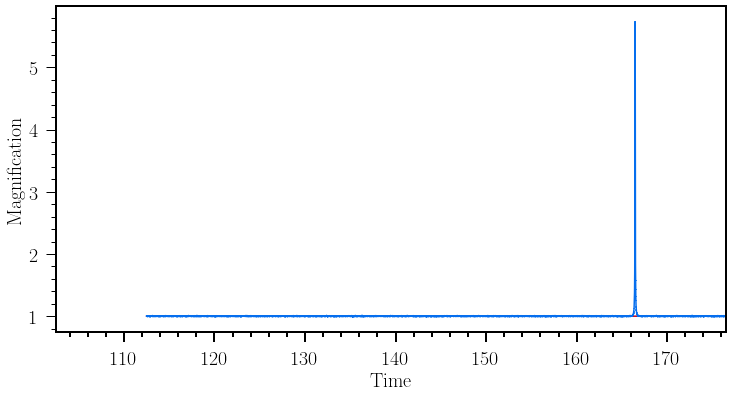

In [14]:
plot_fit(x, y, sigma, opt_roman_PSPL_chi2.x, PSPL)

In [12]:
# # plt.plot(x, y)
# plt.plot(x, PSPL(x, *opt_romax
# # dt = 100
# # plt.xlim(peak-dt, peak+dt)

# MCMC

In [16]:
def log_likelihood(theta, x, y, yerr, func=PSPL):
    ll = -0.5*(np.sum((func(x, *theta) - y)**2 / (yerr**2)))
    return ll


def log_prior(theta):
    x0, tE, u0, fs = theta
    if (160 < x0 < 170) and (0 < tE < 10) and (-np.inf < u0 < np.inf) and (0 < fs < 1):
        return 0
    else:
        return -np.inf


def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [21]:
nwalkers = 32
ndim = len(P0)
pos = P0 + 1e-4 * np.random.randn(nwalkers, ndim)
nsteps = 1000

In [22]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, sigma))
final_state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 1000/1000 [00:12<00:00, 82.18it/s]
